Introdução

---


Até agora, você aprendeu a usar várias cláusulas SQL. Por exemplo, você sabe como usar SELECT para extrair colunas específicas de uma tabela, junto com WHERE para extrair linhas que atendem a critérios especificados. Você também sabe como usar funções agregadas como COUNT(), junto com GROUP BY para tratar várias linhas como um único grupo.

Agora você aprenderá a alterar a ordem de seus resultados usando a cláusula ORDER BY e explorará um caso de uso popular aplicando ordenação a datas. Para ilustrar o que você aprenderá neste tutorial, trabalharemos com uma versão ligeiramente modificada da nossa tabela de animais de estimação familiar.

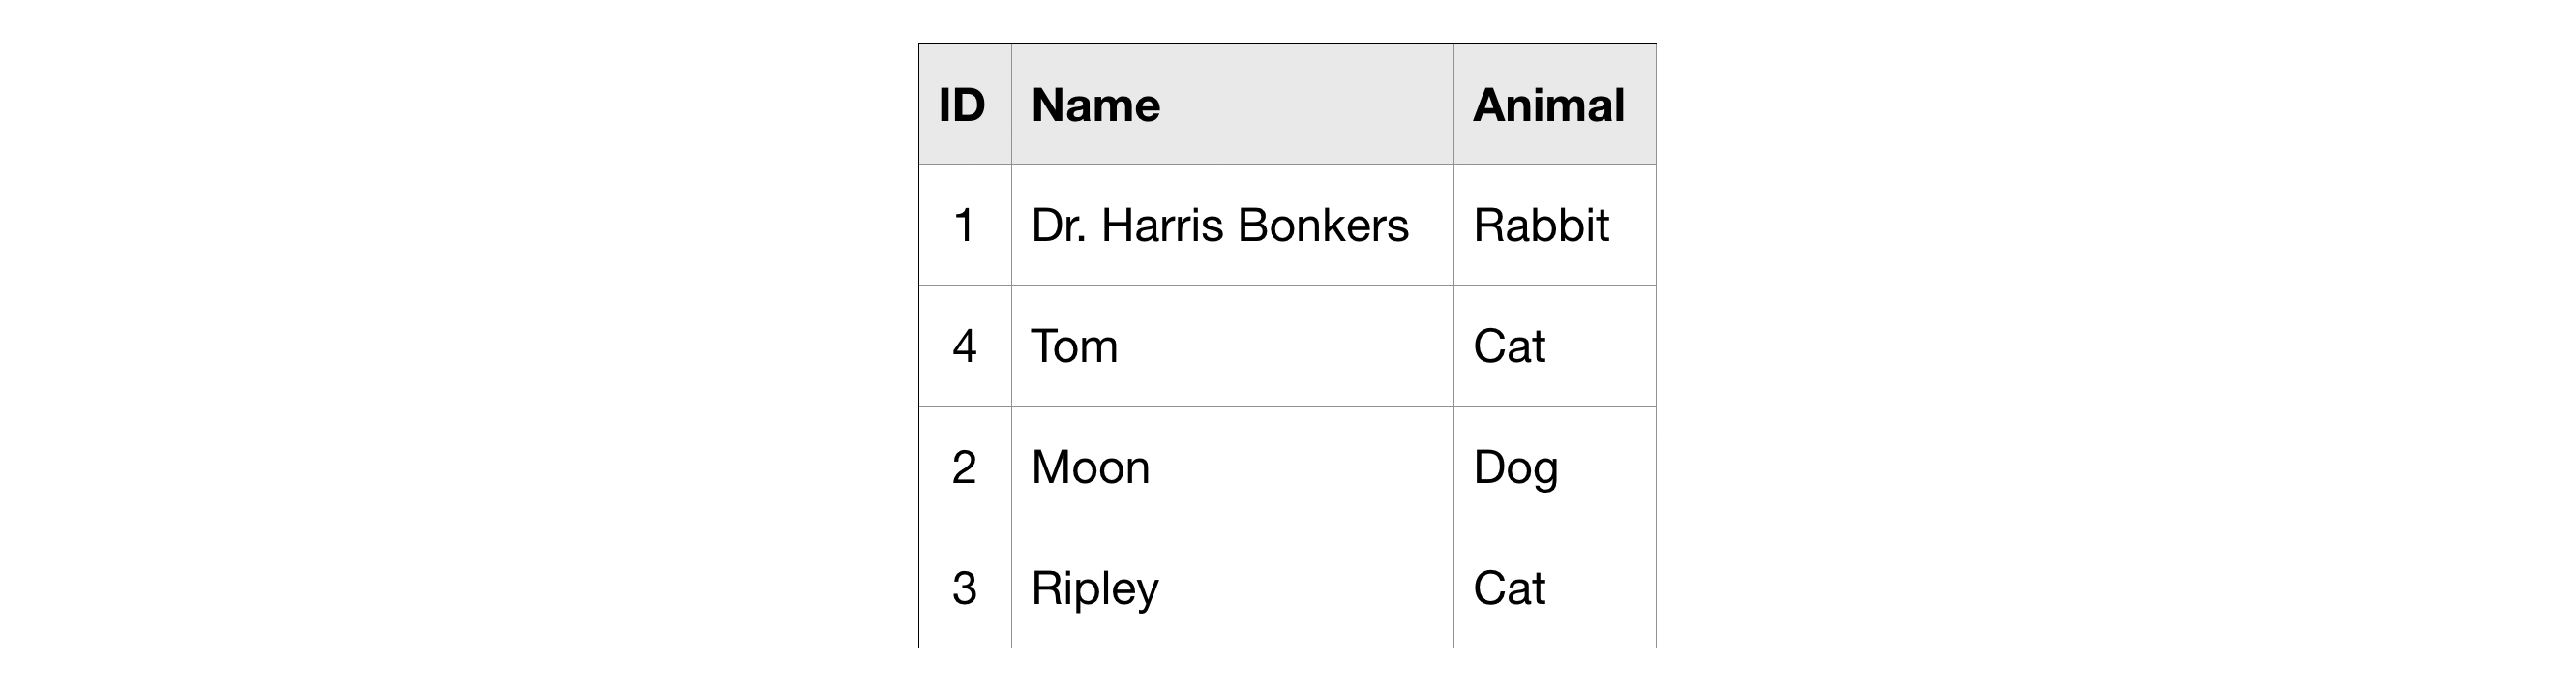

## ORDER BY

---


ORDER BY geralmente é a última cláusula em sua consulta e classifica os resultados retornados pelo restante de sua consulta.

Observe que as linhas não são ordenadas pela coluna ID. Podemos remediar isso rapidamente com a consulta abaixo.
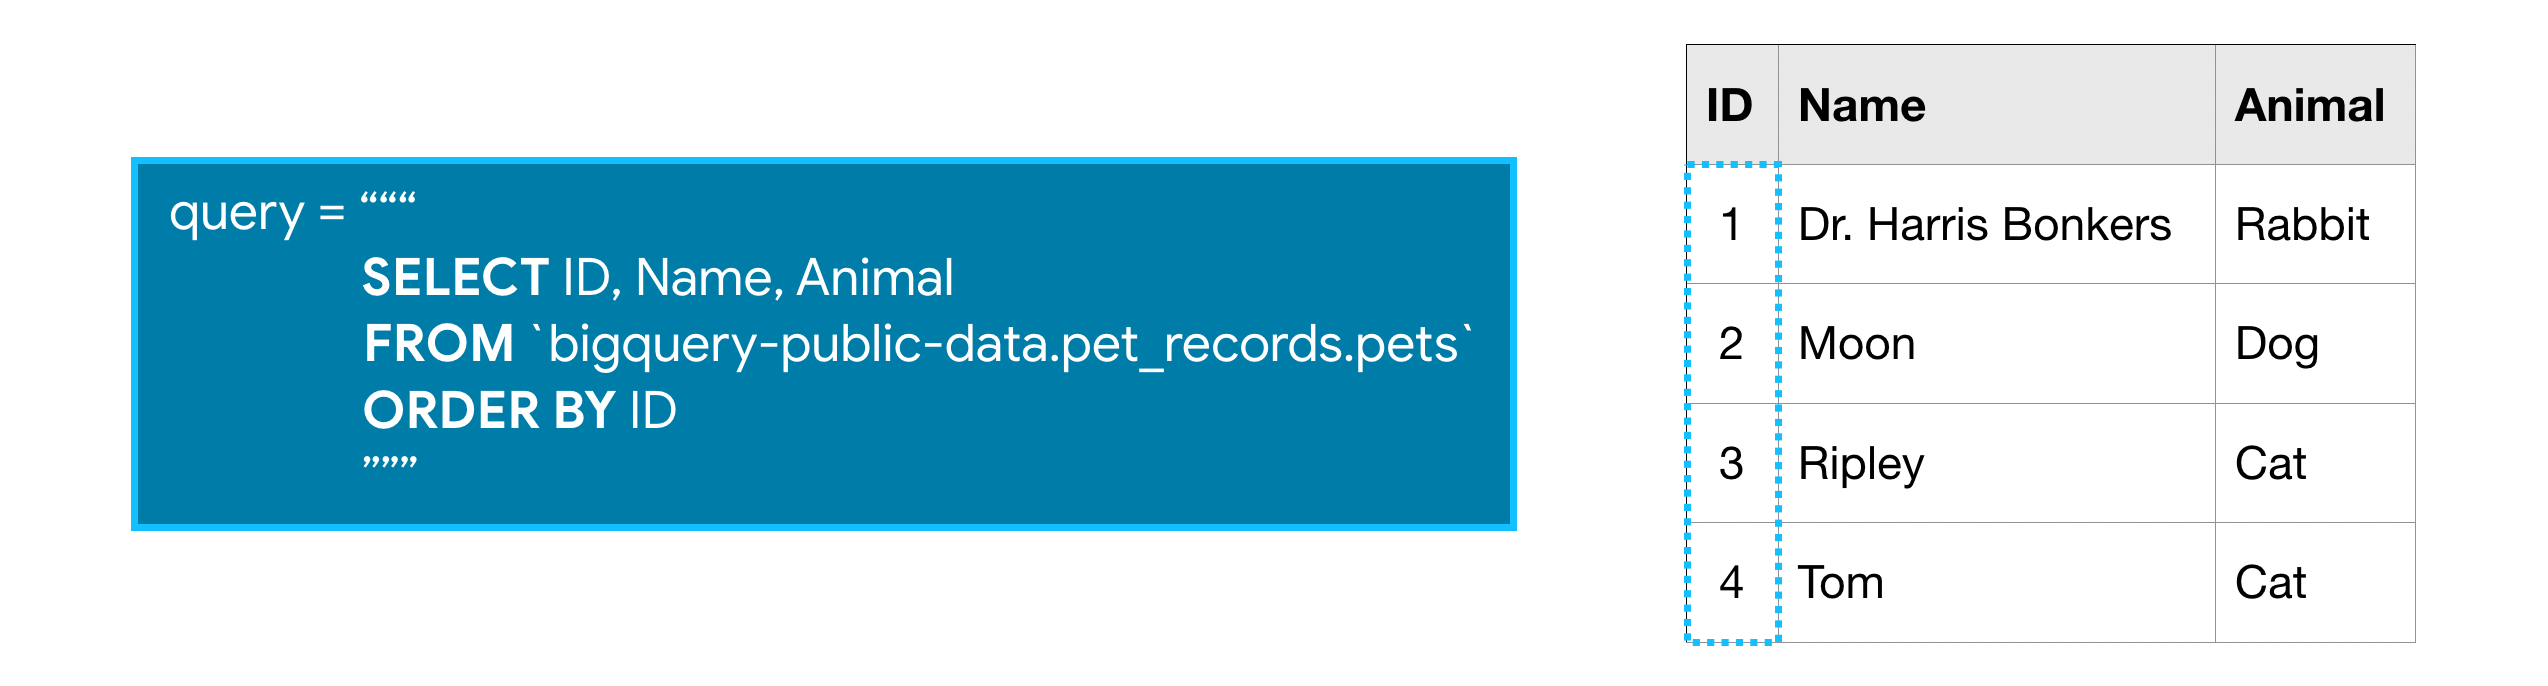

A cláusula ORDER BY também funciona para colunas contendo texto, onde os resultados aparecem em ordem alfabética.

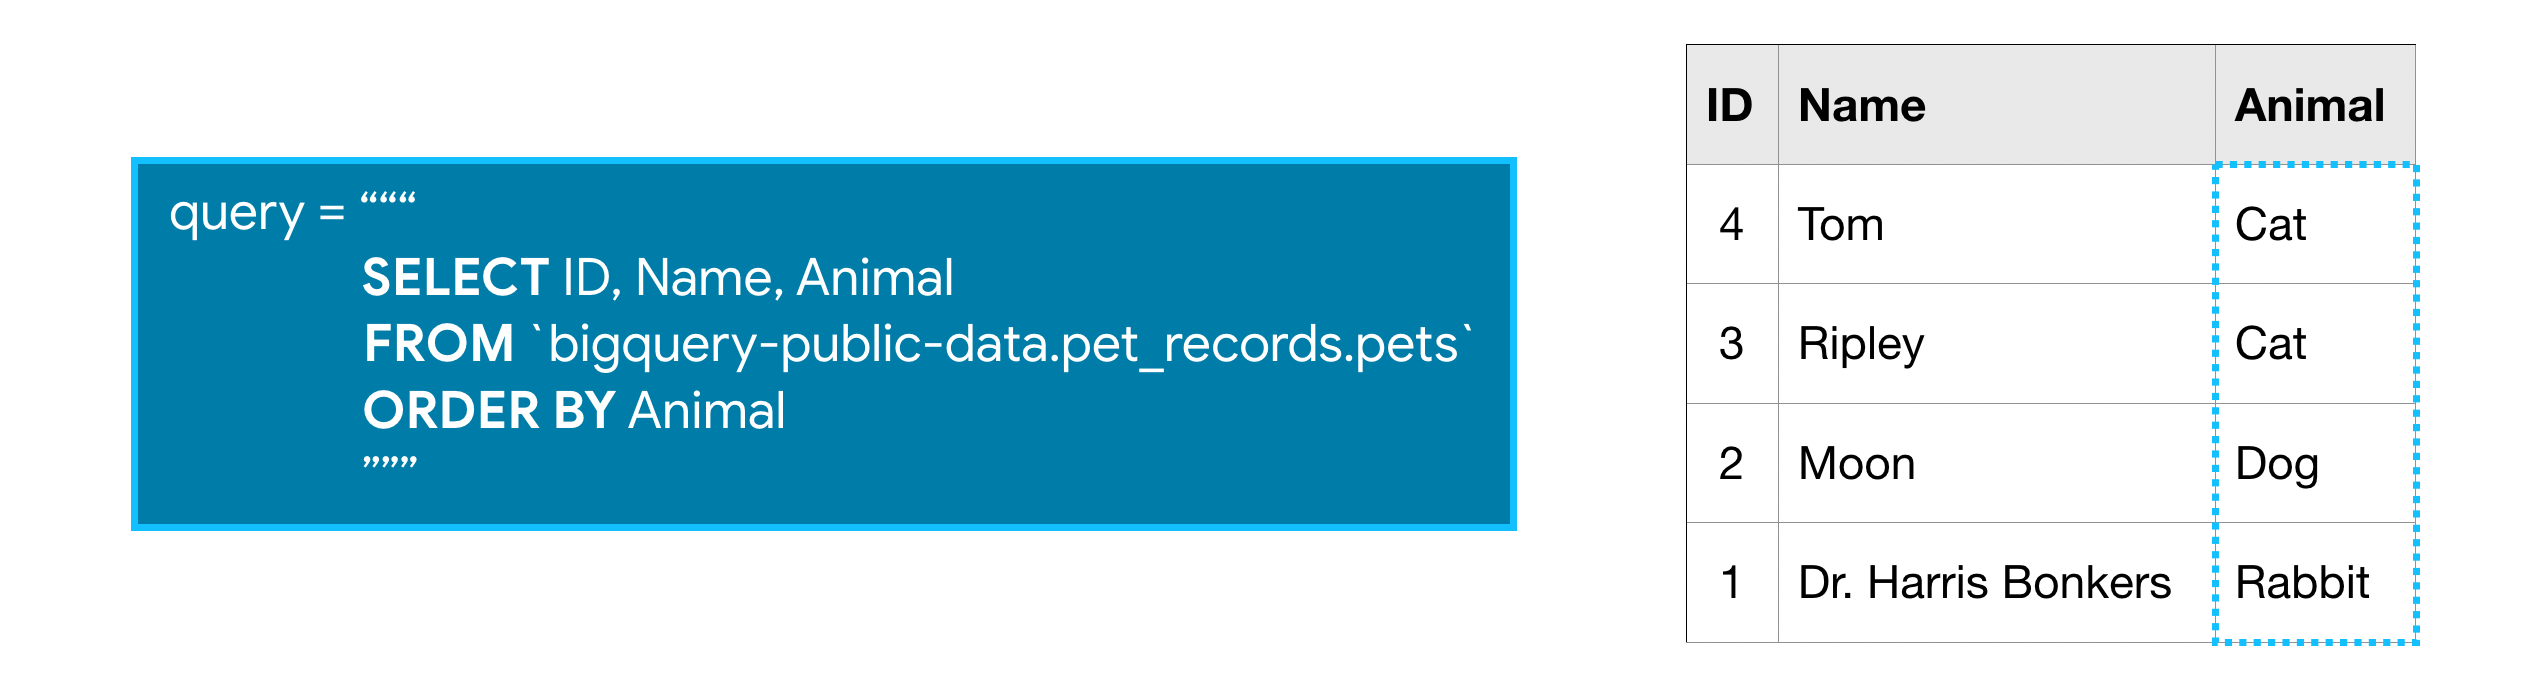

Você pode reverter a ordem usando o argumento DESC (abreviação de 'descendente'). A próxima consulta classifica a tabela pela coluna Animal, onde os últimos valores em ordem alfabética são retornados primeiro

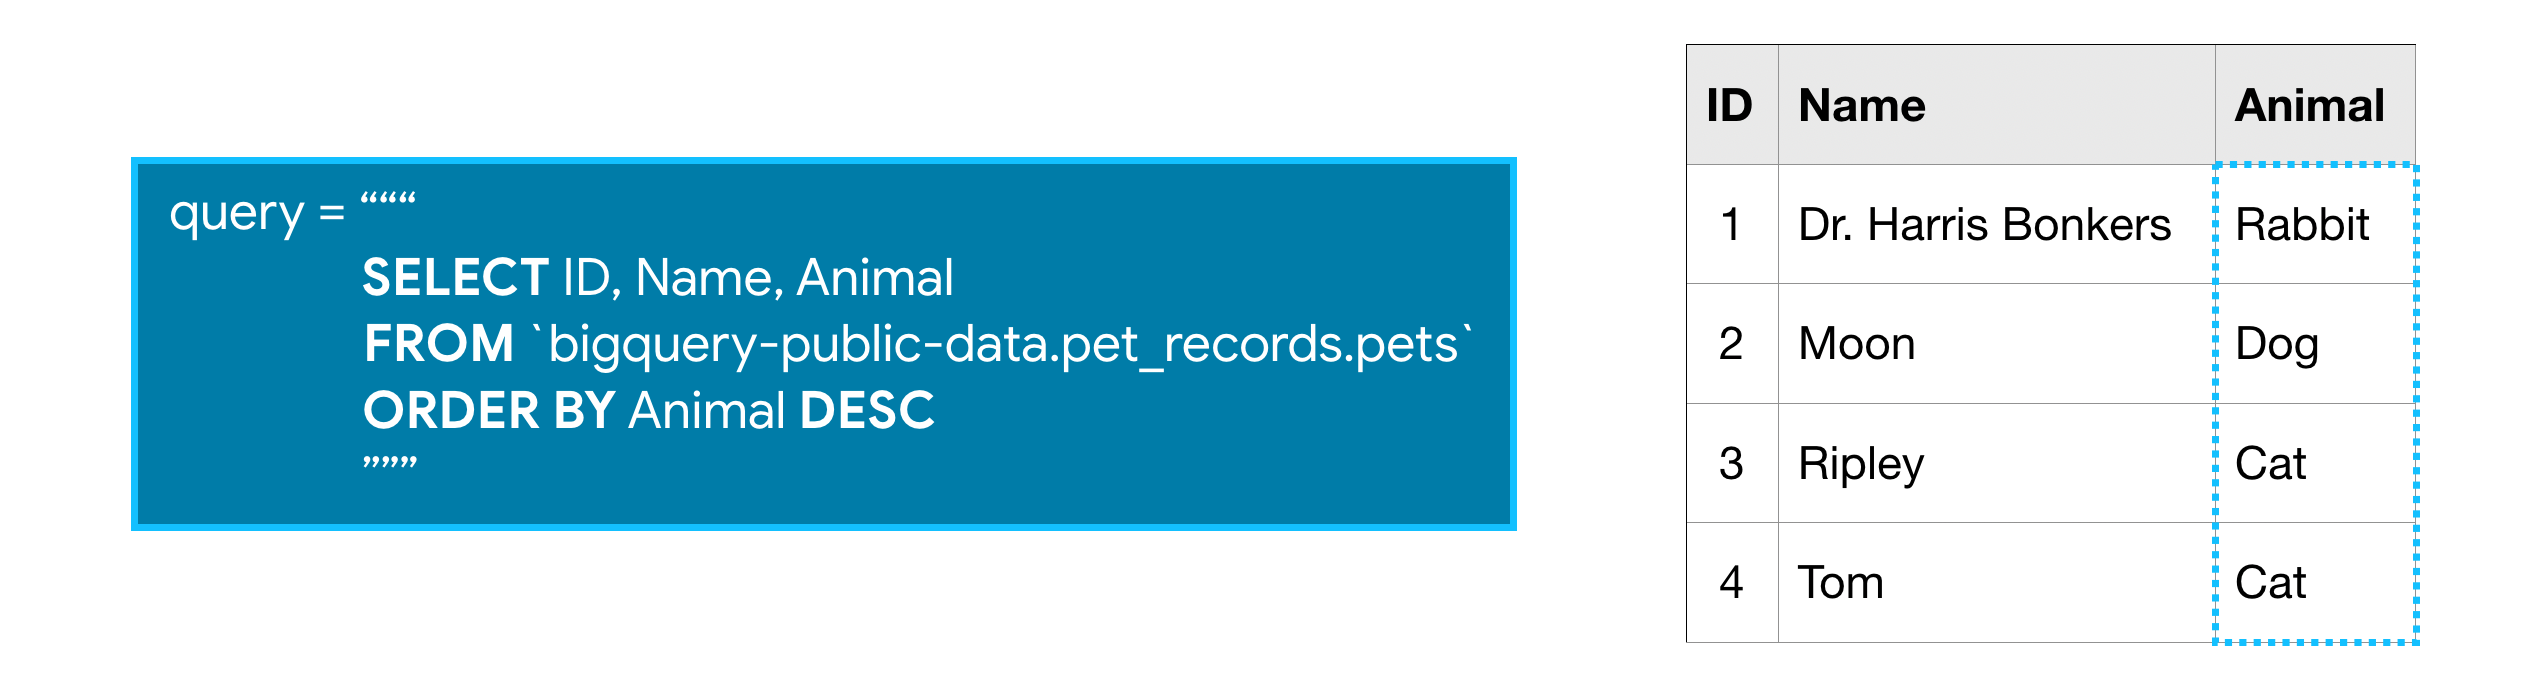

## Datas

---


A seguir, falaremos sobre datas, porque elas aparecem com muita frequência em bancos de dados do mundo real. Há duas maneiras de armazenar datas no BigQuery: como DATE ou como DATETIME.

O formato DATE tem primeiro o ano, depois o mês e depois o dia. Se parece com isso:

* AAAA-[M]M-[D]D
* AAAA: ano de quatro dígitos
* [M]M: mês de um ou dois dígitos
* [D]D: Dia de um ou dois dígitos

Portanto, 2019-01-10 é interpretado como 10 de janeiro de 2019.

O formato DATETIME é como o formato de data... mas com hora adicionada no final.

## EXTRACT

---


Muitas vezes você vai querer olhar para parte de uma data, como o ano ou o dia. Você pode fazer isso com EXTRACT. Ilustraremos isso com uma tabela um pouco diferente, chamada pets_with_date.

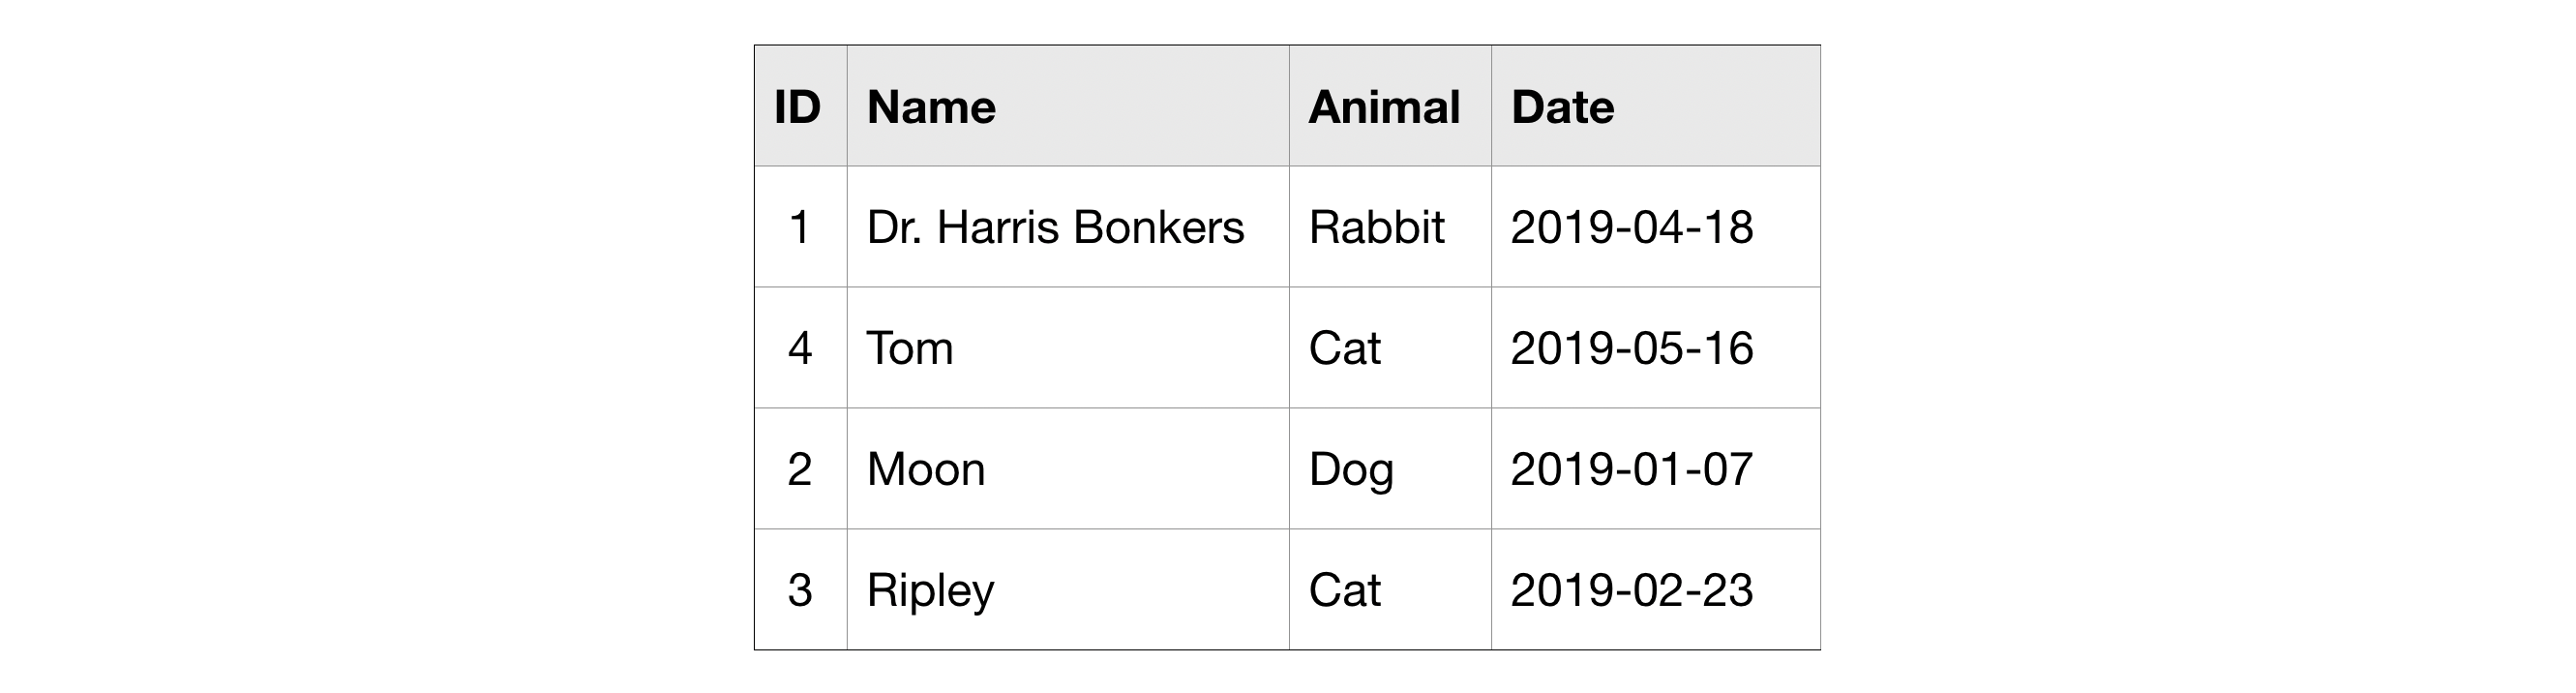

A consulta abaixo retorna duas colunas, onde a coluna Day contém o dia correspondente a cada entrada da coluna Date da tabela pets_with_date:

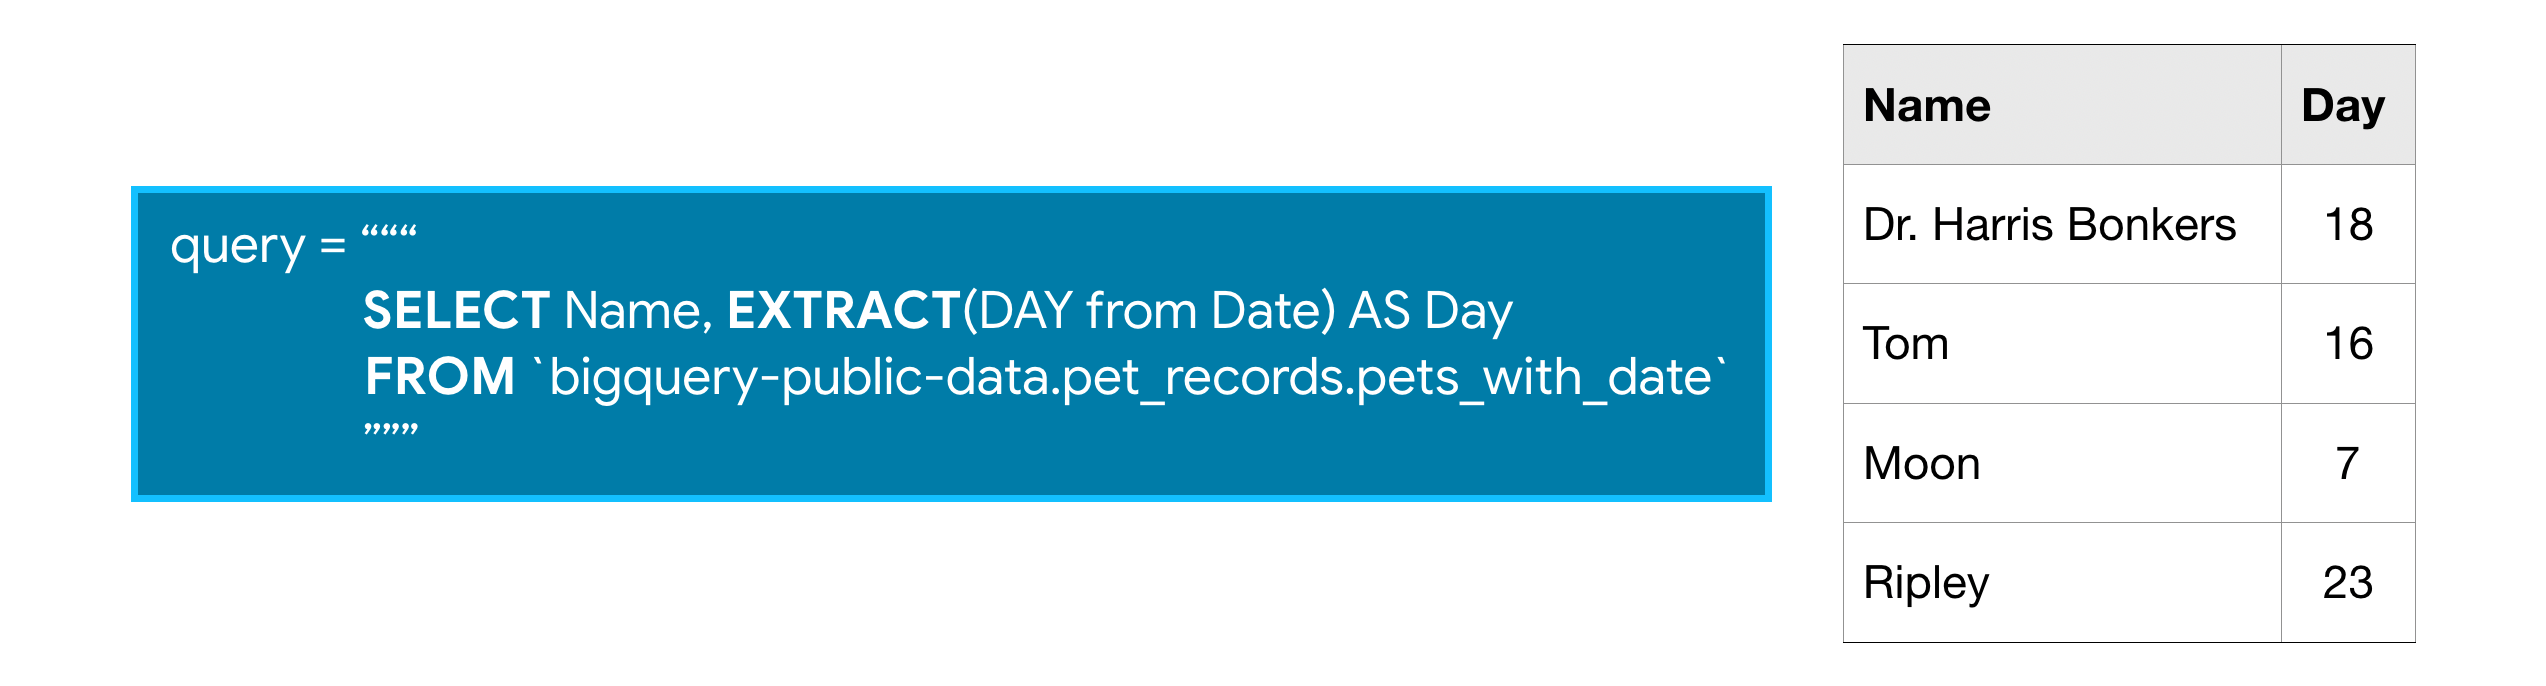

O SQL é muito inteligente com relação a datas, e podemos pedir informações além de apenas extrair parte da célula. Por exemplo, esta consulta retorna uma coluna com apenas a semana do ano (entre 1 e 53) para cada data na coluna Data:

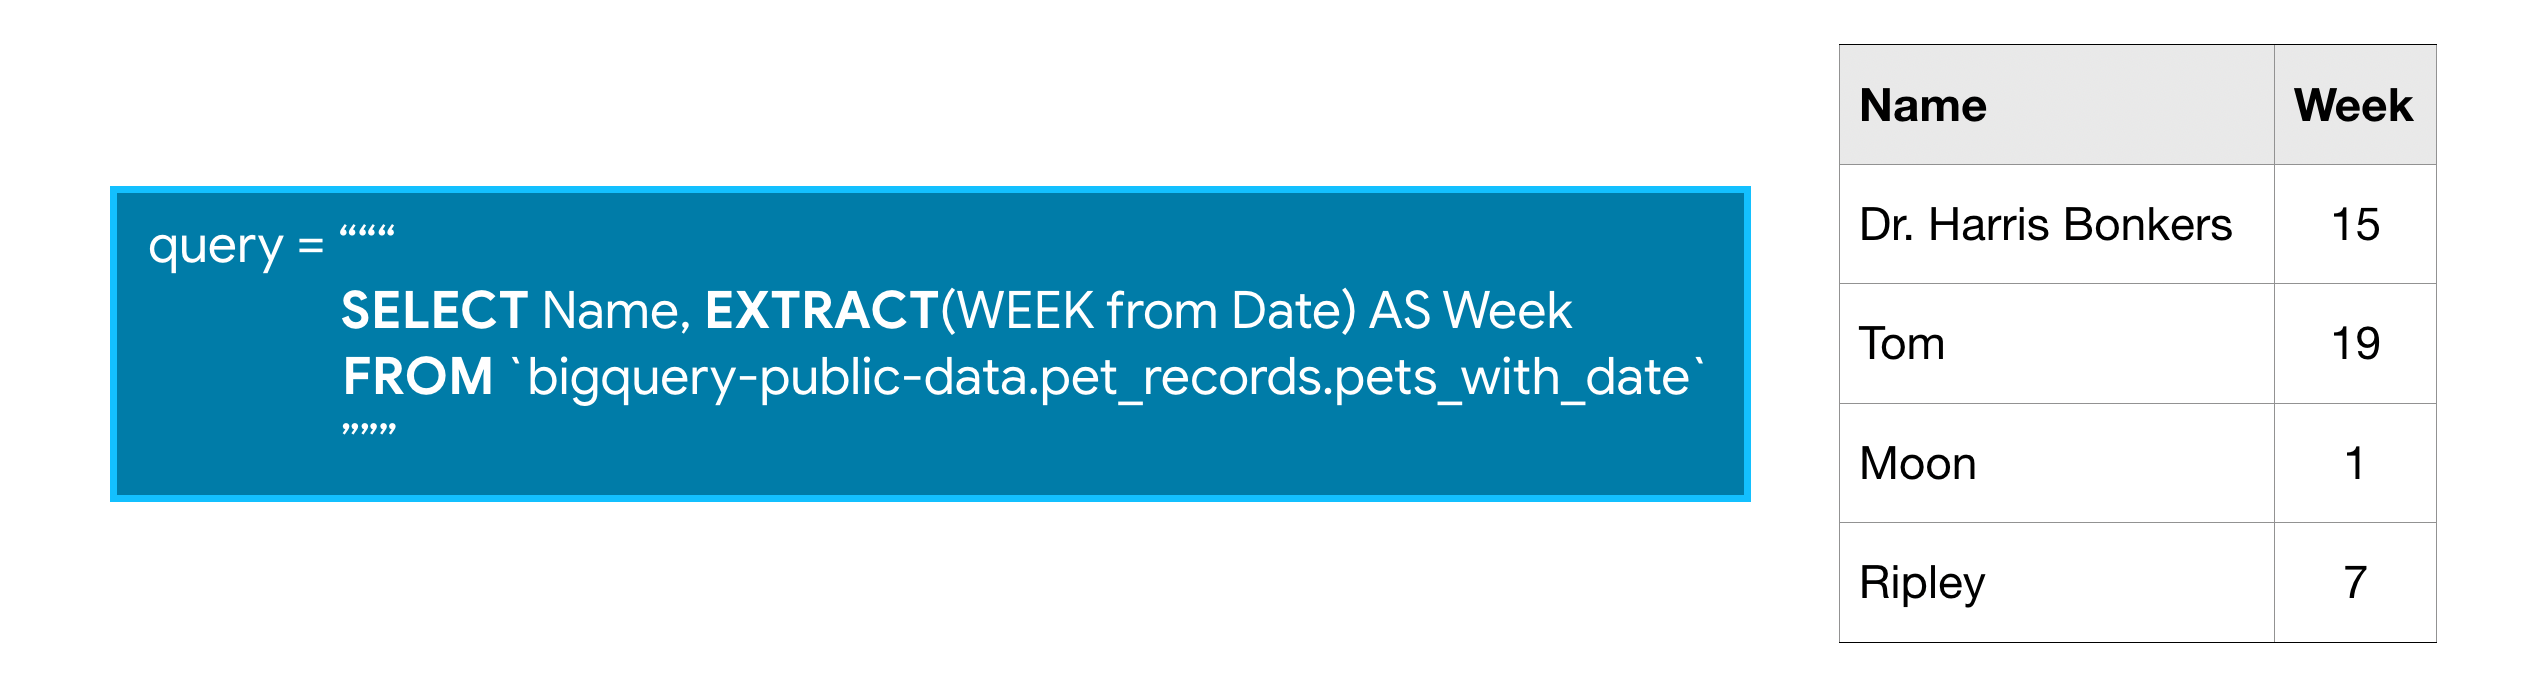

Você pode encontrar todas as funções que pode usar com datas no BigQuery [nesta documentação em "Funções de data e hora".](https://cloud.google.com/bigquery/docs/reference/legacy-sql#datetimefunctions)

## Exemplo: Qual dia da semana tem mais acidentes de trânsito fatais?

---



Vamos usar o banco de dados US Traffic Fatality Records, que contém informações sobre acidentes de trânsito nos EUA onde pelo menos uma pessoa morreu.

Investigaremos a tabela acidente_2015. Aqui está uma visão das primeiras linhas. (Ocultamos o código correspondente.

In [4]:
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "nhtsa_traffic_fatalities" dataset
dataset_ref = client.dataset("nhtsa_traffic_fatalities", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "accident_2015" table
table_ref = dataset_ref.table("accident_2015")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "accident_2015" table
client.list_rows(table, max_results=5).to_dataframe()

Vamos usar a tabela para determinar como o número de acidentes varia com o dia da semana. Desde:

* a coluna número_consecutivo contém um ID exclusivo para cada acidente e
* a coluna timestamp_of_crash contém a data do acidente no formato DATETIME,

podemos:

* EXTRAIR o dia da semana (como day_of_week na consulta abaixo) da coluna timestamp_of_crash e
* GROUP BY o dia da semana, antes de contarmos a coluna do número_consecutivo para determinar o número de acidentes para cada dia da semana.

Em seguida, ordenamos a tabela com uma cláusula ORDER BY, para que os dias com mais acidentes sejam retornados primeiro.

In [5]:
# Query to find out the number of accidents for each day of the week
query = """
        SELECT COUNT(consecutive_number) AS num_accidents, 
               EXTRACT(DAYOFWEEK FROM timestamp_of_crash) AS day_of_week
        FROM `bigquery-public-data.nhtsa_traffic_fatalities.accident_2015`
        GROUP BY day_of_week
        ORDER BY num_accidents DESC
        """

Como de costume, executamos da seguinte forma:

In [ ]:
# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 1 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**9)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
accidents_by_day = query_job.to_dataframe()

# Print the DataFrame
accidents_by_day

Observe que os dados são ordenados pela coluna num_accidents, onde os dias com mais acidentes de trânsito aparecem primeiro.

Para mapear os números retornados da coluna day_of_week para o dia real, consulte a documentação do BigQuery na função DAYOFWEEK. Ele diz que retorna "um inteiro entre 1 (domingo) e 7 (sábado), inclusive". Assim, em 2015, a maioria dos acidentes automobilísticos fatais nos EUA ocorreu no domingo e no sábado, enquanto o menor número aconteceu na terça-feira.